In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import SimpleITK as sitk
import torch

In [2]:
src = Path('./graphic_data')

inputs = sitk.ReadImage(src / 'Dataset038_amos_Dataset006_bcv_cervix_inputs.nii.gz')
uncert = sitk.ReadImage(src / 'Dataset038_amos_Dataset006_bcv_cervix_uncert.nii.gz')
target = sitk.ReadImage(src / 'Dataset038_amos_Dataset006_bcv_cervix_target.nii.gz')
vanilla_logits = torch.load(src / 'merged_logits_Dataset038_amos.pt')
feduwavg_logits = torch.load(src / 'merged_logits_wu_Dataset038_amos.pt')

In [3]:
import json
import numpy as np

with open('LABELS.json', 'r') as f:
    labels = json.load(f)
labels = [list(l['wanted_labels_in_dataset']) for l in labels.values()]
labels = [xx for x in labels for xx in x]
labels = np.unique(labels).tolist()

In [4]:
colors = sns.color_palette() + [(1.,192/255,0.), (0.,32/255,96/255)] # yellow + blue
cp = sns.color_palette(colors)
cp = {l: c for l, c in zip(labels, cp)}

In [5]:
sns.color_palette(cp.values())

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451),
 (1.0, 0.7529411764705882, 0.0),
 (0.0, 0.12549019607843137, 0.3764705882352941)]

In [6]:
colors = {
    1: cp['aorta'], 7: cp['liver'], 11: cp['stomach'], 8: cp['pancreas'], 10: cp['spleen'], 6: cp['right kidney']
}

/tmp/ipykernel_4123793/3840604259.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


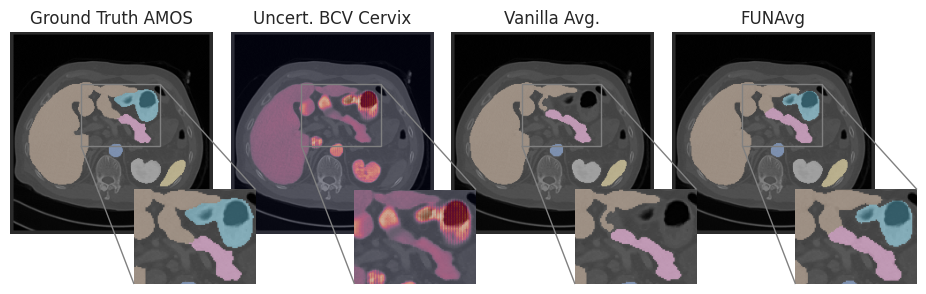

In [7]:
from mpl_toolkits.axes_grid1 import inset_locator

z = 14 # 75 # 51 # 14 # 124 # 143
idx = 45
x = sitk.GetArrayFromImage(inputs[idx:-idx,idx:-idx,z])
t = sitk.GetArrayFromImage(target[idx:-idx,idx:-idx,z])
u = sitk.GetArrayFromImage(uncert[idx:-idx,idx:-idx,z])
vl = vanilla_logits[z,:,idx:-idx,idx:-idx].argmax(0)
feduwavgl = feduwavg_logits[z,:,idx:-idx,idx:-idx].argmax(0)
new_t = np.zeros((*t.shape, 3))
new_vl = np.zeros((*t.shape, 3))
new_feduwavgl = np.zeros((*t.shape, 3))
# {'aorta': }
# for i, l in enumerate(labels):
for i, c in colors.items():
    # print(i+1,l,(t==i+1).sum())
    try:
        new_t[t==i,:] = c#p[l] #i % len(cp)]
        new_vl[vl==i,:] = c#p[l] # i % len(cp)]
        new_feduwavgl[feduwavgl==i,:] = c#p[l] # i % len(cp)]
    except:
        pass
fig, axs = plt.subplots(1,4,figsize=(9,3))
for ax in axs:
    ax.imshow(x, cmap='gray', origin='lower')
    ax.set_axis_off()
axs[0].imshow(new_t, alpha=0.5, origin='lower')
axs[1].imshow(u, alpha=0.5, origin='lower')
axs[2].imshow(new_vl,alpha=0.5, origin='lower')
axs[3].imshow(new_feduwavgl,alpha=0.5, origin='lower')

axs[0].set_title('Ground Truth AMOS')
axs[1].set_title('Uncert. BCV Cervix')
axs[2].set_title('Vanilla Avg.')
axs[3].set_title('FUNAvg')

for ax, img in zip(axs, [new_t, u, new_vl, new_feduwavgl]):
    x1, x2, y1, y2 = 80, 170, 100, 170

    axins = inset_locator.inset_axes(ax, width="150%", height="150%", loc=4,
                                    bbox_to_anchor=(0.85,-0.35, 0.4, 0.4),
                                    bbox_transform=ax.transAxes)
    axins.imshow(x, cmap='gray', origin='lower')
    axins.imshow(img, alpha=0.5, origin='lower')
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.set_axis_off()

    from mpl_toolkits.axes_grid1.inset_locator import mark_inset
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="0.5", facecolor='white')

fig.tight_layout()
fig.savefig('qualitative_pred_amos_rebuttal.png', bbox_inches='tight')